# Assignment — Generative network models

In [190]:
from scipy.stats import ks_2samp
import matplotlib.pyplot as plt
import networkx as nx
from tqdm.notebook import trange, tqdm
import random
import numpy as np

### Task 1. Watts-Strogatz model (0 points)

Implement Watts-Strogatz model (small-world model) — rewire an edge with probability `p` in a ring lattice with `n` nodes and `k` degree.

In [191]:
def watts_strogatz_graph(n, k, p):
    G = ring_lattice(n, k)
    for node in tqdm(G.nodes):
        rewire(G, node, k, p)
    return G

Write a function `ring_lattice` that returns a regular ring lattice with `n` nodes (0, 1, 2, ..., n-1) and `k` node degree. In a case of an odd node degree, it round it to the nearest smaller even number.

In [192]:
def ring_lattice(n, k):
    # YOUR CODE HERE
    #raise NotImplementedError()
    G = nx.Graph()
    nodes = np.arange(n)
    G.add_nodes_from(nodes)

    for i in range(1, int(k / 2 + 1)):
      G.add_edges_from(zip(nodes[:-i], nodes[i:]))
      G.add_edges_from(zip(nodes[-i:], nodes[:i]))

    return G

In [193]:
assert nx.degree_histogram(ring_lattice(10, 2))[2] == 10
assert nx.degree_histogram(ring_lattice(10, 3))[2] == 10
assert nx.degree_histogram(ring_lattice(10, 4))[4] == 10

Write a function `rewire` that takes in input a ring lattice `G`, a `node`, a model parameter `k` and probability `p`. For every right hand side neighbor $i$, the function rewires an edge (`node`, $i$) into a random edge (`node`, $j$) with probability `p` where $i \neq j \neq $ `node`.

*Hints:*
* *Why do we only rewire right hand side edges? We want to guarantee that only untouched in previous iterations edges will be rewound. Look at the picture — we could not move the red edges in previous iterations.*

![](https://raw.githubusercontent.com/netspractice/network-science/main/images/watts_strogatz_how_to_rewire.png)

* *To speed up the generation, do not filter nodes to random selection. If a selected node produces an existing edge or a loop, just skip it.*

In [194]:
def rewire(G, node, k, p):
    # YOUR CODE HERE
    n_nodes = G.number_of_nodes()
    for i in range(node+1, node+int(k / 2 + 1)):
      if np.random.random() < p:
        target = np.random.choice(n_nodes)
        if target != node and not G.has_edge(node, target):
          G.remove_edge(node, i % n_nodes)
          G.add_edge(node, target)
    #raise NotImplementedError()

In [195]:
cases = [[50, 8, 0.1],
         [1000, 10, 0.01],
         [1000, 10, 0.5],
         [1000, 10, 0.99]]
for n, k, p in cases:
    G = watts_strogatz_graph(n, k, p)
    assert nx.number_of_nodes(G) == n
    assert nx.number_of_edges(G) == int(k / 2 * n)
    degree_seq = [degree for (node, degree) in G.degree]
    nxG = nx.watts_strogatz_graph(n, k, p, 1)
    nxdegree_seq = [degree for (node, degree) in nxG.degree]
    assert ks_2samp(degree_seq, nxdegree_seq).pvalue > 0.05

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

Let us draw a small-world graph in some steps of the algorithm

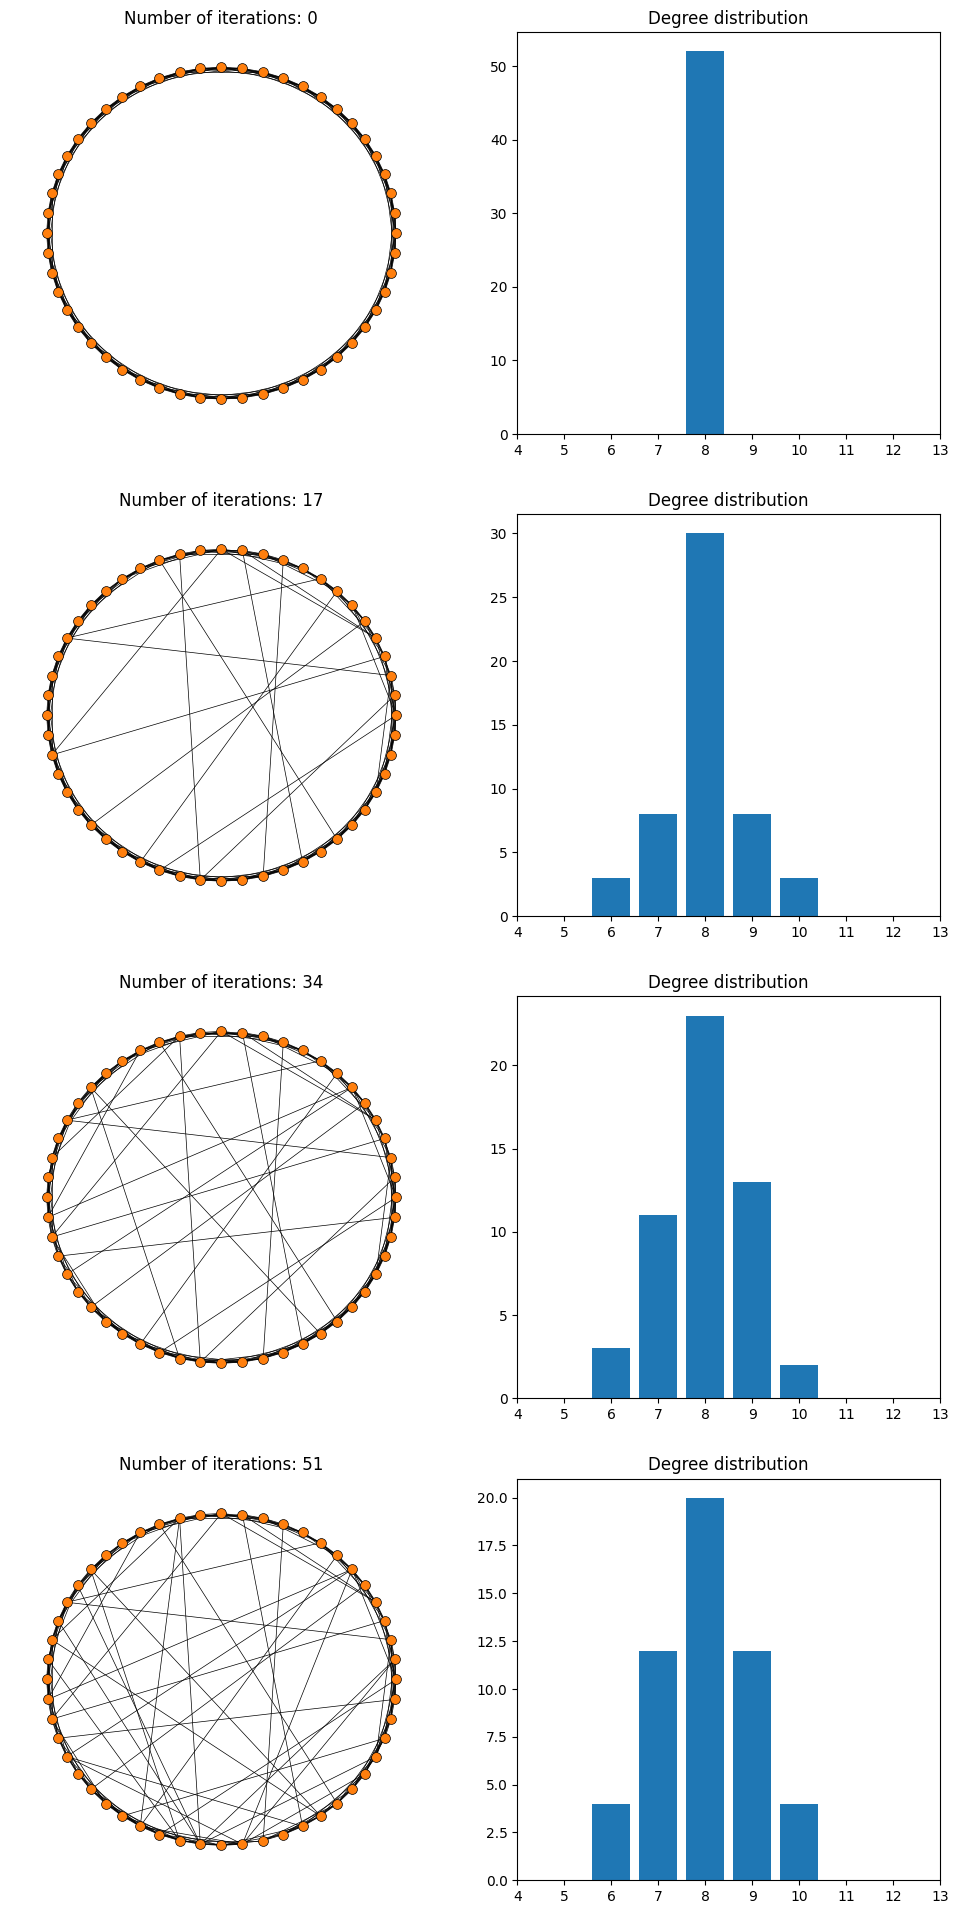

In [196]:
n, k, p = 52, 8, 0.2
G = ring_lattice(n, k)
plt.figure(figsize=(12, 6 * 4))
i = 1
for node in G.nodes:
    if node in np.arange(0, n+1, int(n/3)):
        plt.subplot(4, 2, i)
        plt.title('Number of iterations: {}'.format(node))
        nx.draw_circular(
            G,
            node_size=50,
            width=0.5,
            linewidths=0.5,
            edgecolors='black',
            node_color='tab:orange')
        i += 1
        plt.subplot(4, 2, i)
        degree_seq = [degree for (node, degree) in G.degree]
        bins, freq = np.unique(degree_seq, return_counts=True)
        plt.bar(bins, freq)
        plt.xlim((4, 13))
        plt.title('Degree distribution')
        i += 1
    rewire(G, node, k, p)

### Task 2. Average path length in Watts-Strogatz model (2 points)

Let us check that the average path length tends to theoretical value during building the small-world model.

$$\langle L \rangle = \begin{cases}
N/2k, \text{ if } p \to 0 \\
\log(N)/\log(k), \text{ if } p \to 1
\end{cases}$$

So that we have a lower and upper limits of path lengths for $0 < p < 1$.

Write a function `smallworld_path_len` with Watts-Strogatz model parameters `n, k, p` that returns np.array of average path lengths in each step (node). The length of the array is `n`.

*Hint: to calculate the average shortest path length, use `nx.average_shortest_path_length`*

In [223]:


def smallworld_path_len(n, k, p):
    # Generate a ring lattice network with n nodes and each node connected to k nearest neighbors
    G = ring_lattice(n, k)

    # Initialize an empty list to store average shortest path lengths
    out = []

    # Iterate over each node in the network
    for node in G.nodes:
        # Calculate the average shortest path length of the current network configuration
        avg_shortest_path_length = nx.average_shortest_path_length(G)

        # Append the average shortest path length to the output list
        out.append(avg_shortest_path_length)

        # Rewire the edges of the network for the current node with probability p
        rewire(G, node, k, p)

    # Convert the list of average shortest path lengths to a numpy array and return it
    return np.array(out)


In [224]:
n, k, p = 101, 10, 0.05
lengths = smallworld_path_len(n, k, p)
step_space = np.log(np.arange(1, len(lengths) + 1))
X = np.stack([step_space, np.ones(lengths.shape[0])], axis=1)
assert lengths.shape[0] == n
assert 0.1 < -(np.linalg.pinv(X) @ np.log(lengths))[0] < 0.25

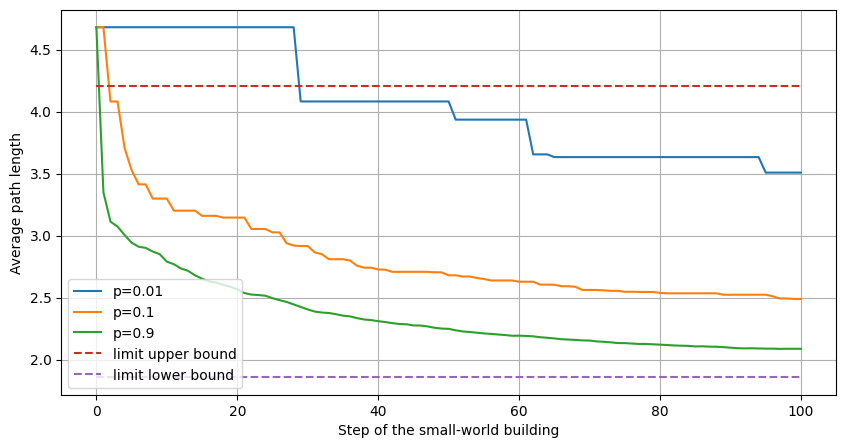

In [225]:
plt.figure(figsize=(10, 5))

n, k, p = 101, 12, 0.01
lengths = smallworld_path_len(n, k, p)
plt.plot(lengths, label=f'p={p}')

n, k, p = 101, 12, 0.1
lengths = smallworld_path_len(n, k, p)
plt.plot(lengths, label=f'p={p}')

n, k, p = 101, 12, 0.9
lengths = smallworld_path_len(n, k, p)
plt.plot(lengths, label=f'p={p}')

plt.xlabel('Step of the small-world building')
plt.ylabel('Average path length')
plt.grid()
plt.plot([0, 100], [n / 2 / k, n / 2 / k], '--',
         label='limit upper bound')
plt.plot([0, 100], [np.log(n) / np.log(k), np.log(n) / np.log(k)], '--',
         label='limit lower bound')
plt.legend(loc='lower left')
plt.show()

### Task 3. Barabasi-Albert model (0 points)

Implement Barabasi-Albert model (preferential attachment model) – a growth process where each new node connects to `m` existing nodes. The higher node degree, the higher probability of the connection. The final number of nodes is `n`.

You start from a star graph with `m + 1` nodes. In each step you create `m` edges between a new node and existing nodes. The probability of connection to the node $i$ is
$$p(i) = \frac{k_i}{\sum k}$$

Write a function `attach` that attaches a `node` to a graph `G` through `m` edges.

*Hint: Create a list with repeated nodes from a list of edges. For example, $[(1, 2), (2, 3), (2, 4)] \to [1, 2, 2, 3, 2, 4]$. Uniformly select nodes one-by-one. Apply `random.choice` instead of `np.random.choice` to speed up the generation.*

In [229]:
'''Do not touch the cell'''
def barabasi_albert_graph(n, m):
    G = nx.star_graph(m)
    for i in trange(1, n - m):
        attach(m + i, G, m)
    return G

In [227]:
def attach(node, G, m):
    # Generate edges list from the graph G
    edges = []
    for edge in G.edges:
        edges.extend(edge)

    # Initialize an empty set to store target nodes for attachment
    targets = set()

    # Randomly select target nodes until the desired number of edges (m) is reached
    while len(targets) < m:
        # Randomly select a node from the edges list and add it to the targets set
        targets.add(edges[np.random.randint(len(edges))])

    # Add edges from the node to the selected target nodes
    G.add_edges_from([(node, target) for target in targets])


In [228]:
G = nx.star_graph(3)
attach(4, G, 3)
assert nx.number_of_edges(G) == 6

cases = [[10, 3],
         [1000, 3],
         [1000, 20]]
for n, m in cases:
    G = barabasi_albert_graph(n, m)
    degree_seq = [degree for (node, degree) in G.degree]
    nxG = nx.barabasi_albert_graph(n, m)
    nxdegree_seq = [degree for (node, degree) in nxG.degree]
    assert ks_2samp(degree_seq, nxdegree_seq).pvalue > 0.05

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/996 [00:00<?, ?it/s]

  0%|          | 0/979 [00:00<?, ?it/s]

Let us see what the growth process looks like

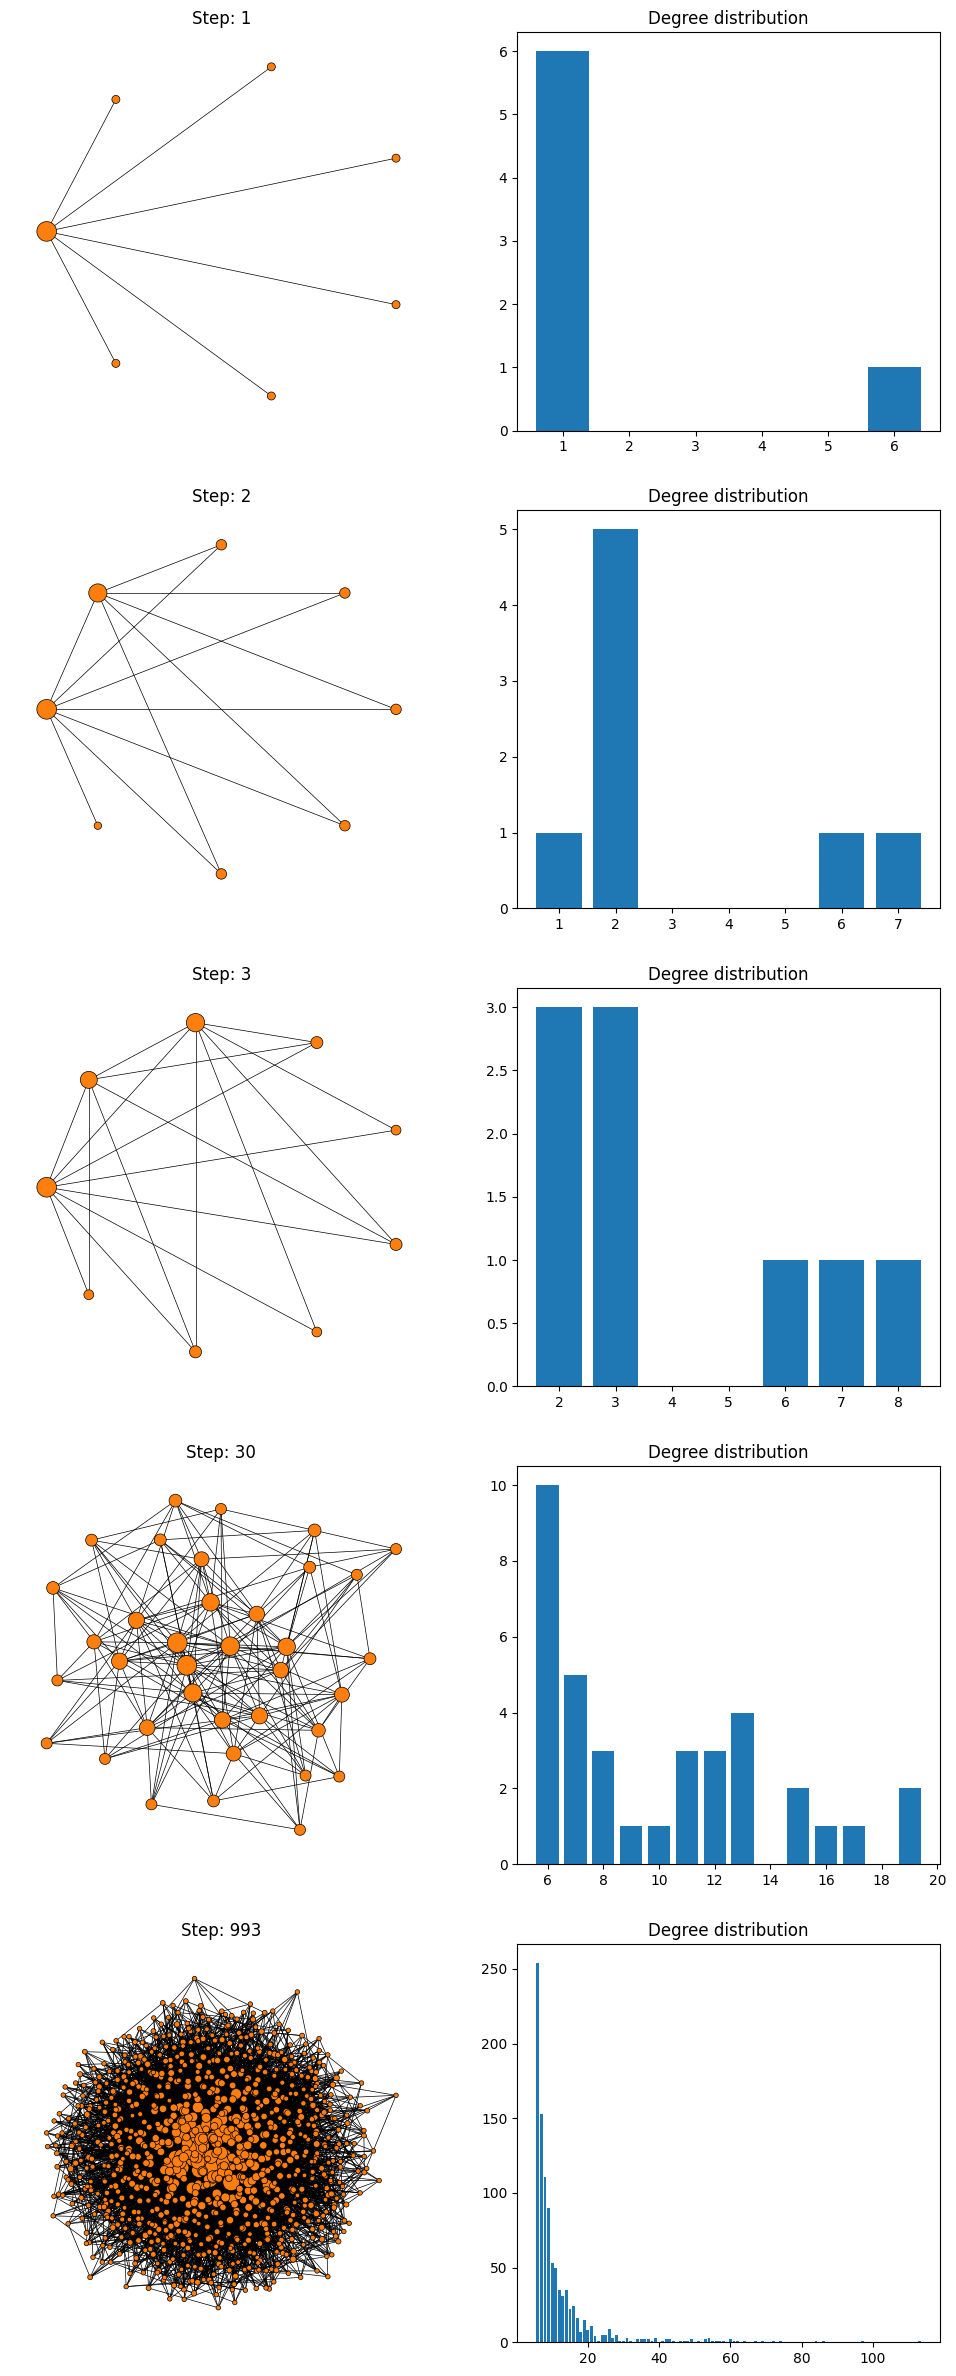

In [203]:
n, m = 1000, 6
G = nx.star_graph(m)
plt.figure(figsize=(12, 6 * 5))
j = 1
for i in range(1, n - m):
    if i in [1, 2, 3, 30, n-m-1]:
        plt.subplot(5, 2, j)
        j += 1
        sizes = np.array(list(nx.degree_centrality(G).values()))
        sizes = sizes / max(sizes) * 200
        if i <= 3:
            pos = nx.layout.shell_layout(G)
        else:
            pos = nx.layout.spring_layout(G)
        nx.draw(
            G,
            pos=pos,
            with_labels=False,
            node_size=sizes,
            width=0.5,
            linewidths=0.5,
            edgecolors='black',
            node_color='tab:orange')
        plt.title('Step: {}'.format(i))
        degree_seq = [degree for (node, degree) in G.degree]
        bins, freq = np.unique(degree_seq, return_counts=True)
        plt.subplot(5, 2, j)
        j += 1
        plt.bar(bins, freq)
        plt.title('Degree distribution')
    attach(m + i, G, m)

### Task 4. Degree distribution in Barabasi-Albert model (3 points)

Barabasi-Albert graph has a degree distribution of the form

$$P(k) = \frac{2m^2}{k^3}$$

That is Power law with $\alpha = 3$ and $k_\min = m$.

Check this fact by an experiment — generate a set of Barabasi-Albert graphs and estimate parameters of Power law using MLE

$$\alpha = 1 + n \left[\sum_i \log \frac{k_i}{k_\min} \right]^{-1}$$

where the $k_\min$ is selected by minimal Kolmogorov-Smirnov distance between observed and theoretical distributions.

First, write a function `power_law_cdf` that takes an argument and parameters of the Power law distribution and returns the CDF.

In [230]:
def power_law_cdf(k, alpha=3.5, k_min=1):
    """
    Calculate the cumulative distribution function (CDF) of a power-law distribution.

    Parameters:
    - k: Array-like or scalar, the values at which to evaluate the CDF.
    - alpha: float, the exponent of the power-law distribution (default: 3.5).
    - k_min: float, the minimum value of the distribution (default: 1).

    Returns:
    - Array-like or scalar, the value of the cumulative distribution function at each point in k.
    """
    # Calculate the value of the power-law CDF at each point in k
    cdf_values = 1 - k ** (1 - alpha) / k_min ** (1 - alpha)
    return cdf_values


In [231]:
assert power_law_cdf(2, 2, 1) == 0.5
assert power_law_cdf(10, 2, 1) == 0.9

Next, write a function `mle_power_law_params` that takes a degree sequence and returns a tuple: the best $\alpha$, w.r.t. MLE, the best $k_\min$ w.r.t. Kolmogorov-Smirnov distance

_Hint: use `scipy.stats.kstest` where a theoretical CDF is a `power_law_cdf` function and `args=(alpha, k_min)`_

In [236]:
from scipy.stats import kstest

def alpha(X, x_min):
    """
    Calculate the alpha parameter of the power-law distribution given a dataset X and minimum value x_min.

    Parameters:
    - X: Array-like, the dataset.
    - x_min: float, the minimum value for calculating alpha.

    Returns:
    - float, the calculated alpha parameter.
    """
    # Filter the dataset to include only values greater than or equal to x_min,
    # then compute the mean of the logarithm of these values and adjust it by adding 1.
    return 1 + 1 / (np.log(X[X >= int(x_min)] / x_min)).mean()

def mle_power_law_params(X):
    """
    Estimate the parameters of a power-law distribution using Maximum Likelihood Estimation (MLE).

    Parameters:
    - X: Array-like, the dataset.

    Returns:
    - Tuple, containing the estimated alpha parameter and the corresponding x_min value.
    """
    # Initialize variables to store the best x_min and the minimum Kolmogorov-Smirnov statistic
    best_x_min = None
    best_stat = np.inf

    # Iterate over unique values of x_min in the dataset X
    for x_min in np.unique(X)[:-1]:
        # Calculate the alpha parameter using the alpha function
        a = alpha(X, x_min)

        # Compute the Kolmogorov-Smirnov statistic for the power-law fit
        # using kstest and the power_law_cdf function
        curr_stat = kstest(
            X[X >= int(x_min)], lambda x: power_law_cdf(x, alpha=a, k_min=x_min)
        )[0]

        # Update the best statistic and x_min if the current statistic is smaller
        if curr_stat < best_stat:
            best_stat, best_x_min = curr_stat, x_min

    # Return the estimated alpha parameter and the corresponding x_min value
    return alpha(X, best_x_min), best_x_min


In [237]:
assert mle_power_law_params(np.array([1, 2, 3]))[0] > 0
assert mle_power_law_params(np.array([1, 2, 3]))[1] > 0

Write a function `estimate_power_law` that generates Barabasi-Albert graphs with `n` nodes, from `m_min` to `m_max` connections and returns a tuple of np.arrays: $\alpha$ and $k_{\min}$ for each graph.

In [238]:
def estimate_power_law(n, m_min, m_max):
    """
    Estimate the parameters of a power-law distribution for Barabasi-Albert graphs with varying m values.

    Parameters:
    - n: int, the number of nodes in the generated graphs.
    - m_min: int, the minimum number of edges to attach from a new node to existing nodes.
    - m_max: int, the maximum number of edges to attach from a new node to existing nodes.

    Returns:
    - Tuple, containing arrays of estimated alpha parameters and corresponding k_min values.
    """
    # Initialize lists to store estimated alpha parameters and k_min values
    alpha = []
    k_min = []

    # Iterate over the range of m values from m_min to m_max
    for m in range(m_min, m_max + 1):
        # Create a star graph with m nodes
        G = nx.star_graph(m)

        # Iterate over the remaining nodes to attach edges
        for i in range(1, n - m):
            attach(m + i, G, m)

        # Estimate the parameters of the power-law distribution for the current graph
        # using the Maximum Likelihood Estimation (MLE) method
        a, k = mle_power_law_params(
            np.array([degree for node, degree in list(G.degree)])
        )

        # Append the estimated alpha parameter and k_min value to the respective lists
        alpha.append(a)
        k_min.append(k)

    # Convert the lists of alpha parameters and k_min values to numpy arrays and return them as a tuple
    return np.array(alpha), np.array(k_min)


In [239]:
'''Check the Power law parameters'''
n, m_min, m_max = 500, 2, 20
alpha, k_min = estimate_power_law(n, m_min, m_max)
assert alpha.shape[0] == m_max - m_min + 1
assert 2 < alpha.mean() < 4
assert k_min[0] < k_min[-1]


<ipython-input-230-de6332904d96>:14: RuntimeWarning: invalid value encountered in divide
  cdf_values = 1 - k ** (1 - alpha) / k_min ** (1 - alpha)


<ipython-input-230-de6332904d96>:14: RuntimeWarning: invalid value encountered in divide
  cdf_values = 1 - k ** (1 - alpha) / k_min ** (1 - alpha)


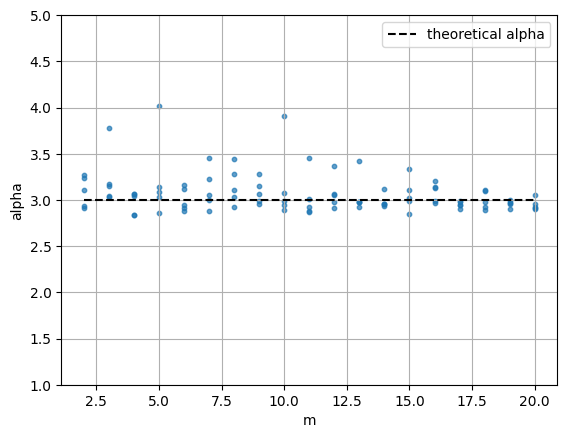

In [240]:
n, m_min, m_max = 500, 2, 20
m_space = np.arange(m_min, m_max + 1)
for _ in range(5):
    alpha, k_min = estimate_power_law(n, m_min, m_max)
    plt.scatter(m_space, alpha, alpha=0.7, c='tab:blue', s=10)
plt.plot([2, 20], [3, 3], 'k--', label='theoretical alpha')
plt.ylim((1, 5))
plt.xlabel('m')
plt.ylabel('alpha')
plt.grid()
plt.legend()
plt.show()

### Task 5. Clustering coefficient in Barabasi-Albert model (2 points)

Measure the average clustering coefficient in function of N using Barabasi-Albert model.

Write a function `generate_clustering_coef` that takes np.array with list of `n` values for each graph and parameter `m`. The function generate Barabasi-Albert graphs and returns np.array of average clustering coefficients.

In [241]:
def generate_clustering_coef(n_list, m):
    """
    Generate clustering coefficients for Barabasi-Albert graphs with varying numbers of nodes.

    Parameters:
    - n_list: list, containing the numbers of nodes for the generated graphs.
    - m: int, the number of edges to attach from a new node to existing nodes.

    Returns:
    - numpy array, containing the clustering coefficients for the generated graphs.
    """
    # Initialize an empty list to store clustering coefficients
    clustering_coefs = []

    # Iterate over each value of n in the list of numbers of nodes
    for n in n_list:
        # Generate a Barabasi-Albert graph with n nodes and m edges to attach
        G = nx.barabasi_albert_graph(n, m)

        # Calculate the average clustering coefficient of the graph
        clustering_coef = nx.average_clustering(G)

        # Append the clustering coefficient to the list
        clustering_coefs.append(clustering_coef)

    # Convert the list of clustering coefficients to a numpy array and return it
    return np.array(clustering_coefs)


In [242]:
n_list = np.arange(100, 3100, 100)
m = 6
coeffs = generate_clustering_coef(n_list, m)
assert coeffs.shape == (30,)
X = np.log(n_list)
X = np.stack([np.ones_like(X), X], axis=1)
Y = np.log(coeffs)[:, None]
assert -0.78 < (np.linalg.pinv(X) @ Y)[1][0] < -0.63

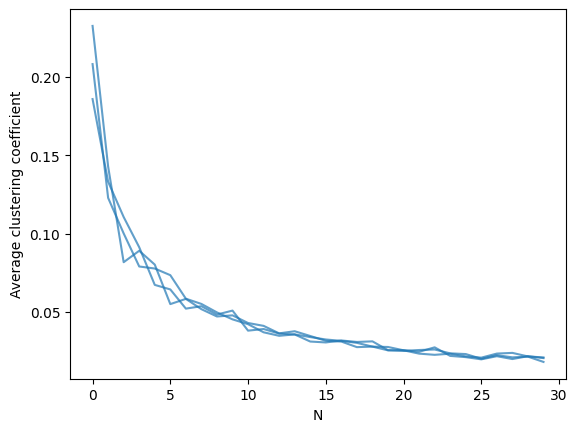

In [243]:
n_list = np.arange(100, 3100, 100)
m = 6
for _ in range(3):
    coeffs = generate_clustering_coef(n_list, m)
    plt.plot(coeffs, c='tab:blue', alpha=0.7)
plt.xlabel('N')
plt.ylabel('Average clustering coefficient')
plt.show()

### Task 6. Degree dynamics in Barabasi-Albert model (3 points)

Measure the degree dynamics in Barabasi-Albert model of one of the initial nodes and of the nodes added to the network at intermediate time moments (steps of the algorithm).

Write a function `generate_degree_dynamics` that takes np.array with considered nodes, generates Barabasi-Albert graph ($n=3000$, $m=6$) and returns a np.array of the shape `(30, len(cons_nodes))` — degrees of these nodes at time moments when nodes 99, 199, 299, ..., 2999 appear. If a node does not exist yet, pass `np.nan` value.

*Hint: use the `barabasi_albert_graph` function as a template*

In [244]:
def generate_degree_dynamics(cons_nodes):
    """
    Generate degree dynamics for nodes in a Barabasi-Albert graph.

    Parameters:
    - cons_nodes: list, containing node IDs for which to generate degree dynamics.

    Returns:
    - numpy array, containing the degree dynamics for the specified nodes.
    """
    # Set the total number of nodes and the initial number of edges to attach
    n = 3000
    m = 6

    # Initialize an empty list to store degree dynamics
    out = []

    # Create a star graph with m nodes
    G = nx.star_graph(m)

    # Define moments at which to record degree dynamics
    moments = set(np.arange(99, 3000, 100))

    # Iterate over each node in the network
    for i in range(1, n + 1):
        # Check if the current node is in the set of moments
        if i in moments:
            # Calculate the degrees of the specified nodes and append them to the output list
            degrees = [G.degree(node) if node in G.nodes else np.nan for node in cons_nodes]
            out.append(np.array(degrees))

        # Attach edges to the current node
        attach(m + i, G, m)

    # Convert the list of degree dynamics to a numpy array and return it
    return np.array(out)


In [245]:
degree_dynamics = generate_degree_dynamics([99, 199, 699, 1999])
assert degree_dynamics.shape == (30, 4)
assert np.all(np.isnan(degree_dynamics[0]) == [False, True,  True,  True])
assert np.all(np.isnan(degree_dynamics[9]) == [False, False,  False,  True])
assert degree_dynamics[0, 0] < degree_dynamics[-1, 0]
assert degree_dynamics[1, 1] < degree_dynamics[-1, 1]
assert degree_dynamics[-1, 0] > degree_dynamics[-1, 3]

  0%|          | 0/5 [00:00<?, ?it/s]

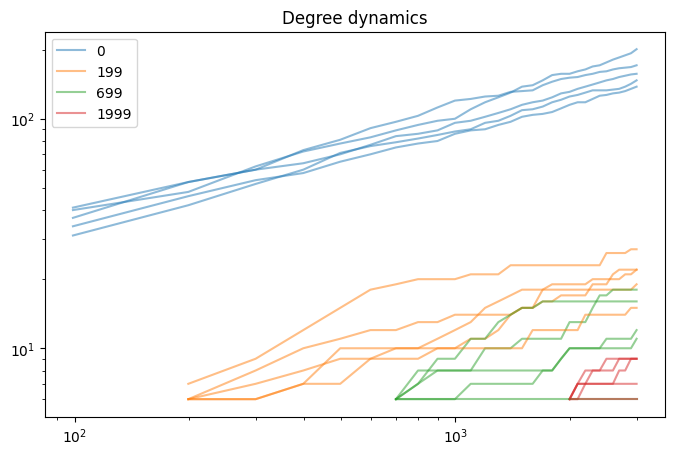

In [246]:
cons_nodes = [0, 199, 699, 1999]
colors = plt.cm.tab10.colors
plt.figure(figsize=(8, 5))
for _ in trange(5):
    degree_dynamics = generate_degree_dynamics(cons_nodes)
    time_space = np.arange(99, 3000, 100)
    for i in range(4):
        plt.plot(time_space, degree_dynamics[:, i], c=colors[i], alpha=0.5)
plt.legend(cons_nodes)
plt.title('Degree dynamics')
plt.xscale('log')
plt.yscale('log')
plt.show()